# Übung 1 - Modellierung von PV-Stromerzeugung

Gruppe 2/B

Autoren: Ahmed Akhi, Johannes Gerger, Markus Heitzinger

In [98]:
# Import von Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math


from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [99]:
laengengrad=16.3
breitengrad=48.2
Modulwirkungsgrad = 0.17 # Wirkungsgrad der Panele
SonstigeVerluste = 0.8 # Wirkungsgrad aller anderen Komponenten...
Installpv = 1 # installierte Leistung der Anlage in kWp

 # Ausrichtung der PV
pv_hoehenwinkel=20  #Neigungswinkel der Anlage
pv_azimut=180       #Azimut der Anlage (Süden bei Uns)
Systemkostenkwp=2000 # €/kWp Systemkosten
A = 0.2 #Albedo
E_0 = 1367 #W/m^2

dfTime = pd.read_csv("time.csv");
dfStrahlung = pd.read_csv("Strahlung.csv");
dfTemperatur = pd.read_csv("Temperatur.csv");

__Vorgegebene Funktion zur Bestimmung des relativen Sonnenstands:__

In [100]:
def sonnenstand(laengengrad,breitengrad,time):
    """
    Diese Funktion erstellt einen Vektor für den Sonnenstand in 15 min
    Auflösung über ein Jahr

    die Variable "azimut" ergibt einen Vektor des azimuts über ein Jahr
    der azimut ergibt nur für positive Hoehenwinkel verlässliche Werte, da
    die atan-Funktion nur Abweichungen bis zu 90° liefert. In weiteren 
    Berechnungen sollten also nur jene Werte mit positiven Hoehenwinkeln 
    (nach Sonnenaufgang) verwendet werden. Für die Berechnung von PV-Erträgen
    reicht dies vollkommen aus. 
    die Variable "hoehenwinkel" ergibt einen Vektor aller hoehenwinkel über 
    ein Jahr
    für Schaltjahre muss die Berechnung dementsprechend angepasst werden. Dies
    Anpassung muss im Rahmen dieser LV allerdings nicht berücksichtigt werden.

    Quellen zur Berechnung des Sonnenstands: Ursula Eicker(2012), 
    Jakob Anger(2012), Rainer Blabensteiner(2011)

    Args:
        laengengrad: float
        breitengrad: float
        time: pandas.Dataframe

    Returns:
        azimut: numpy.array
        hoehenwinkel: numpy.array
    
    """
    ## Zeitgleichung zur Berechnung der wahren Ortszeit
    
    # Zeitgleichung - ergibt die 
    # Abweichung der Sonnenuhr von der mittlerer Ortszeit(MOZ)
    hw1 = 360 / 365 * time['Tag'] # Hilfswinkel 1
    
    z = 0.008 * np.cos(np.radians(hw1)) - 0.122 * np.sin(np.radians(hw1)) \
        - 0.052 * np.cos(np.radians(2 * hw1)) - 0.157 * np.sin(np.radians(2 * hw1)) \
        - 0.001 * np.cos(np.radians(3 * hw1)) - 0.005 * np.sin(np.radians(3 * hw1))

    WOZ = time['Stunden'] + z + 1 / 15 * laengengrad - math.floor(1/15 * laengengrad) # Wahre Ortszeit (WOZ), der Vektor 
    # time.Stunden entspricht der mittleren Ortszeit (MOZ) in Stunden
    
    ## Stundenwinkel bei Berechnung über True Solar Time
    # time.Stunden entspricht hier der Sonnenzeit und nicht der Ortszeit
    # Stw=15*time.Stunden; #Stundenwinkel 
    Stw = 15 * WOZ # Stundenwinkel
    
    ## Berechnung der Deklination
    
    Ew = 0.98630 * (np.array(time.Tag) - 2.8749) + 1.9137 * np.sin(np.radians(0.98630 * (np.array(time.Tag) - 2.8749))) + 102.06 # Ekliptikale Länge in Grad    
    Dw = np.degrees(np.arcsin(-0.3979 * np.sin(np.radians(Ew)))) # Winkel zwischen Äquatorebene und Verbindungs-
    # linie Sonne-Erde. Dieser Winkel wird als Sonnendeklination bezeichnet
    # und schwankt über das Jahr zwischen 23°26,5' und -23°26,5'

    ## Berechnung des Höhenwinkels

    hoehenwinkel = np.degrees(np.arcsin(np.sin(np.radians(Dw)) * np.sin(np.radians(breitengrad)) - np.cos(np.radians(Dw)) * np.cos(np.radians(breitengrad)) * np.cos(np.radians(Stw))))

    ## Berechnung des Azimuts
    # Winkel nach Sonnenuntergang werden hier nicht vollständig abgebildet

    azimutfull = 180 + np.degrees(np.arctan(-np.cos(np.radians(Dw)) * np.sin(np.radians(Stw)) / (-np.cos(np.radians(Dw)) * np.sin(np.radians(breitengrad)) * np.cos(np.radians(Stw)) - np.sin(np.radians(Dw)) * np.cos(np.radians(breitengrad)))))
    
    
    azimutfull[hoehenwinkel < -20] = 0 # Eliminiert
    # unter -20°

    azimutaufteilung = np.reshape(np.array(azimutfull), (96, 365), order="F") # teilt Vektor auf Tage auf
    az1 = azimutaufteilung[0:int((len(time['Stunden'])//365)//2), :] # ergibt Werte für die erste Tageshälfte
    az1[az1 > 220] = az1[az1 > 220] - 180 # Korrektur der Winkel für Abweichungen von über 90° aus Südrichtung
    az11 = az1[0:int(len(time['Stunden'])//365*0.25), :]
    az11[az11 >= 180] = az11[az11 >= 180] - 180
    az1[0:len(az11[:, 0]), :] = az11

    az2 = azimutaufteilung[int((len(time['Stunden'])//365)//2):, :] # ergibt Werte für die zweite Tageshälfte
    az2[(az2 < 150) & (az2 > 0)] = az2[(az2 < 150) & (az2 > 0)] + 180 # Korrektur der Winkel für Abweichungen von über 90° aus Südrichtung
    az22 = az2[int(len(az2[:, 0])*0.5):, :]
    az22[(az22 <= 180) & (az22 > 0)] = az22[(az22 <= 180) & (az22 > 0)] + 180
    az2[int(len(az2[:, 0])-len(az22[:, 0])):, :] = az22
    
    print(len(az1) + len(az2))
    azimutaufteilung = np.concatenate((az1, az2), axis=0) # Zusammenfassung der ersten und zweiten Tageshälfte
    azimut = np.reshape(azimutaufteilung, (35040, ), order="F") # reshape der Tage in einen Vektor aller Winkel über den Jahresverlauf in 15min Intervalle

    return azimut, hoehenwinkel


## 1. Übungsangabe I - III: Modellimplementierung

In [101]:
def jahreserzeugung(laengengrad,breitengrad, Installpv, Modulwirkungsgrad, pv_hoehenwinkel, pv_azimut, SonstigeVerluste,A, dfTime):
    dfSonnenstand = pd.DataFrame(sonnenstand(laengengrad, breitengrad,dfTime))
    dfSonnenstand = dfSonnenstand.transpose()
    dfSonnenstand.rename(columns = {0:'Azimut'}, inplace = True)
    dfSonnenstand.rename(columns = {1:'Höhenwinkel'}, inplace = True)
    #dfSonnenstand["Höhenwinkel"].plot()


    dfSonnenstand["Moduleinfallswinkel"] = np.degrees(np.arccos(-np.cos(np.radians(dfSonnenstand["Höhenwinkel"]))*np.sin(np.radians(pv_hoehenwinkel))*np.cos(np.radians(dfSonnenstand["Azimut"]-pv_azimut-180))+np.sin(np.radians(dfSonnenstand["Höhenwinkel"]))*np.cos(np.radians(pv_hoehenwinkel))))
    #theta_vec =                                      np.arccos(-np.cos(np.deg2rad(hoehenwinkel_reshaped       ))*np.sin(np.deg2rad(pv_hoehenwinkel))*np.cos(np.deg2rad(azimut - pv_azimut - 180             ))+np.sin(np.deg2rad(hoehenwinkel_reshaped       ))*np.cos(np.deg2rad(pv_hoehenwinkel)))
    #dfSonnenstand["Moduleinfallswinkel"].plot()
    #Strahlungsenergien
        #Direkte
    dfSonnenstand["EdirGen"] = dfStrahlung["DirectHoriz"] * np.maximum(0, np.cos(np.radians(dfSonnenstand["Moduleinfallswinkel"]))/np.sin(np.radians(dfSonnenstand["Höhenwinkel"])))
    dfSonnenstand["EdirGen"] = dfSonnenstand["EdirGen"].fillna(0)

    dfSonnenstand["EreflGen"] = dfStrahlung["GlobalHoriz"]*A*(1/2)*(1-np.cos(np.radians(pv_hoehenwinkel)))
    dfSonnenstand["EdiffGen"] = dfStrahlung["DiffusHoriz"] * (1 + np.cos(np.radians(pv_hoehenwinkel))) / 2

    #Aus Angabe (Höhenwinkel)
    #dfSonnenstand.loc[dfSonnenstand["Höhenwinkel"] < 5] = 0

     
    #Fläche der Anlage unter maximaler Leistung in m^2 (R_stc*A)
    PV_A = Installpv

    #Gesamtstrahlungsenergie
    dfSonnenstand["EgGen"] = (dfSonnenstand["EdirGen"] + dfSonnenstand["EdiffGen"] + dfSonnenstand["EreflGen"])*PV_A*SonstigeVerluste

    #Pmax = np.zeros(shape=(35040, 1)) 
    #Gesamtenergie
    dfSonnenstand.loc[dfSonnenstand['Moduleinfallswinkel'] < 5, 'EgGen'] = 0
    Pmax = dfSonnenstand["EgGen"] #* PV_A * SonstigeVerluste * 4
    E = dfSonnenstand["EgGen"].sum()
    print("Jährliche Stromerzeugung (ohne Temp): " + str(round(E*10**(-3), 5)) + " kWh")
    print("Jährliche Volllaststunden (ohne Temp): "+ str(round(E*10**(-3), 5)) + " h/a")

    #print(dfSonnenstand[150:175])
    return Pmax

In [102]:
def jahreserzeugung_temp():
    dfSonnenstand = pd.DataFrame(sonnenstand(laengengrad, breitengrad,dfTime))
    dfSonnenstand = dfSonnenstand.transpose()
    dfSonnenstand.rename(columns = {0:'Azimut'}, inplace = True)
    dfSonnenstand.rename(columns = {1:'Höhenwinkel'}, inplace = True)

    dfSonnenstand["Moduleinfallswinkel"] = np.degrees(np.arccos(-np.cos(np.radians(dfSonnenstand["Höhenwinkel"]))*np.sin(np.radians(pv_hoehenwinkel))*np.cos(np.radians(dfSonnenstand["Azimut"]-pv_azimut-180))+np.sin(np.radians(dfSonnenstand["Höhenwinkel"]))*np.cos(np.radians(pv_hoehenwinkel))))
     
    #Strahlungsenergien
    dfSonnenstand["EdirGen"] = dfStrahlung["DirectHoriz"] * np.maximum(0, np.cos(np.radians(dfSonnenstand["Moduleinfallswinkel"]))/np.sin(np.radians(dfSonnenstand["Höhenwinkel"])))
    dfSonnenstand["EdirGen"] = dfSonnenstand["EdirGen"].fillna(0)

    dfSonnenstand["EreflGen"] = dfStrahlung["GlobalHoriz"]*A*(1/2)*(1-np.cos(np.radians(pv_hoehenwinkel)))
    dfSonnenstand["EdiffGen"] = dfStrahlung["DiffusHoriz"] * (1 + np.cos(np.radians(pv_hoehenwinkel))) / 2

    #Gesamtstrahlungsenergie
    dfSonnenstand["EgGen"] = dfSonnenstand["EdirGen"]+dfSonnenstand["EdiffGen"]+dfSonnenstand["EreflGen"]

    dfSonnenstand.loc[dfSonnenstand['Moduleinfallswinkel'] < 5, 'EgGen'] = 0
    Pmax = dfSonnenstand["EgGen"] #* PV_A * SonstigeVerluste * 4
    
    #Temperatur_15m =  Temperatur_15m.reshape((35040, 1))
    Temperatur_15m = np.array([(x, x, x, x) for x in dfTemperatur.values]).flatten()

    #Werte aus bereitgelegter Doku Huld_et
    c_t = 0.026
    k_1 = -0.017162
    k_2 = -0.040289
    k_3 = -0.004681
    k_4 = 0.000148
    k_5 = 0.000169
    k_6 = 0.000005

    G_raw = Pmax
    G_Hoch = np.where(G_raw != 0, np.log(G_raw / 1000), 0)
    Wirk_temp = 1 + k_1 * G_Hoch + k_2 * (G_Hoch ** 2) + (Temperatur_15m + c_t * G_raw - 25) * (k_3 + k_4 * G_Hoch + k_5 * (G_Hoch ** 2)) + k_6 * ((Temperatur_15m + c_t * G_raw - 25) ** 2)

    PV_A = 1

    Pmax = G_raw * PV_A * SonstigeVerluste * Wirk_temp

    return  Pmax

## 2. Übungsangabe IV: Vergleichen von Ergebnissen

## a.) Leistungsdauerlinie

In [103]:
def leistungsdauerlinie(energy_array,title):
    # Since our models produce arrays of 35040 entries of 15 minute intervals
    # To create the hourly value we average the values over each hour
    energy_array = np.divide(energy_array, 0.25)
    energy_array = np.sort(energy_array, axis=None)[::-1]
    print(energy_array[0:5])
    fig, ax = plt.subplots()
    ax.fill_between(np.arange(0.25, 8760.25, 0.25), energy_array.flatten())
    ax.set_title(title)
    ax.set_xlabel('t in h')
    ax.set_ylabel('P in W')
    ax.grid(True)
    plt.show()

96
Jährliche Stromerzeugung (ohne Temp): 995.2412 kWh
Jährliche Volllaststunden (ohne Temp): 995.2412 h/a
96
[1792.3446784   784.37832921  783.09370764  782.4173468   781.78518001]


d:\STUFF\Anaconda\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


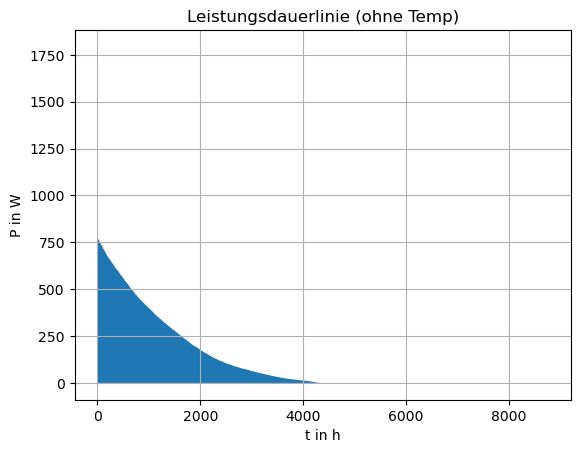

[1688.67551667  744.56546708  742.48585283  739.87507349  738.70319824]


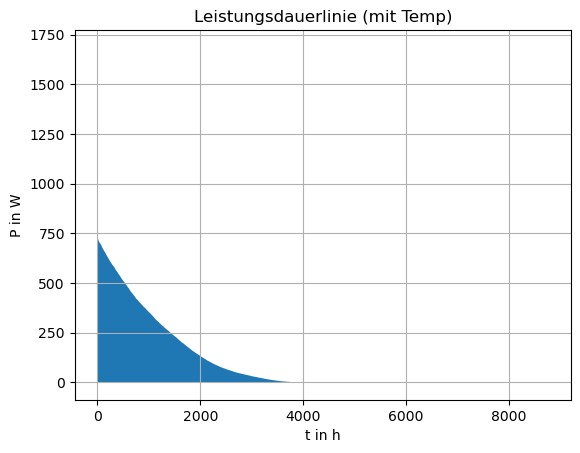

In [104]:
# Modell ohne Temperatur
P_PV = jahreserzeugung(laengengrad,breitengrad, Installpv, Modulwirkungsgrad, pv_hoehenwinkel, pv_azimut, SonstigeVerluste,A, dfTime)
#Modell mit Temperatur
P_PV_Temp = jahreserzeugung_temp()

leistungsdauerlinie(P_PV, "Leistungsdauerlinie (ohne Temp)")
leistungsdauerlinie(P_PV_Temp, "Leistungsdauerlinie (mit Temp)")

## b.) Monatliche Leistungserträge

In [105]:
def monthly_yield_plot(energy_array, title):
    # Creation of daily array
    E_days = np.empty(shape=(365, 1))
    E_days = np.sum(np.reshape(energy_array, (365, 4, 24)), axis=(1, 2))
    
    # Creation of monthly array
    month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    E_months_cumsum = np.cumsum(month_days)  # Kumulative Summe der Tage pro Monat
    E_months = np.empty(shape=(12,))
    E_months[0] = np.sum(E_days[:E_months_cumsum[0]])  # Erster Monat
    for i in range(1, 12):
        E_months[i] = np.sum(E_days[E_months_cumsum[i - 1]:E_months_cumsum[i]])  # Folgende Monate

    fig, ax = plt.subplots()
    ax.bar(np.arange(1, 13), E_months.flatten() / 1000, zorder=2)
    ax.set_title(title)
    ax.set_xlabel('t in Months')
    ax.set_ylabel('Yield in kWh')
    ax.grid(True, zorder=1)
    plt.show()

96
Jährliche Stromerzeugung (ohne Temp): 995.2412 kWh
Jährliche Volllaststunden (ohne Temp): 995.2412 h/a
96


d:\STUFF\Anaconda\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


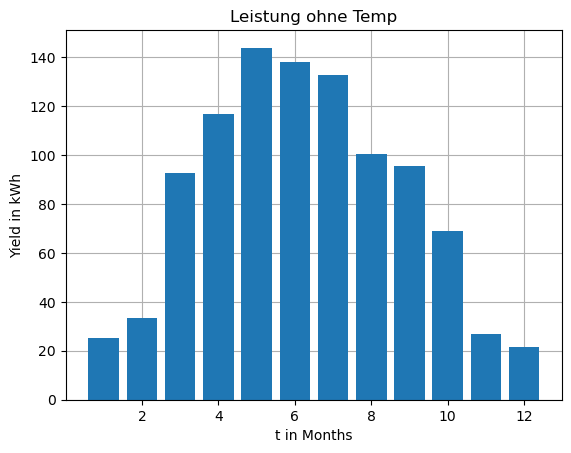

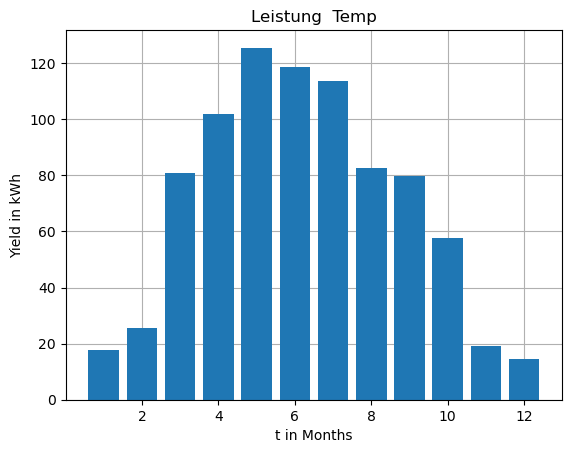

In [106]:
# Modell ohne Temperatur
P_PV = jahreserzeugung(laengengrad,breitengrad, Installpv, Modulwirkungsgrad, pv_hoehenwinkel, pv_azimut, SonstigeVerluste,A, dfTime)
#Modell mit Temperatur
P_PV_Temp = jahreserzeugung_temp()

monthly_yield_plot(P_PV,"Leistung ohne Temp")
monthly_yield_plot(P_PV_Temp,"Leistung  Temp")

## c.) Tage Min/Max PV Erzeugung

In [107]:
# Berechne die täglichen Erträge
daily_yield = np.empty(shape=(365,))
for index in range(365):
    daily_yield[index] = np.sum(P_PV[index * 24 * 4:(index + 1) * 24 * 4])

# Sortiere die täglichen Erträge in aufsteigender und absteigender Reihenfolge
sorted_daily_yield_asc = np.argsort(daily_yield)
sorted_daily_yield_desc = np.flip(sorted_daily_yield_asc)

# Wähle die ersten und letzten 5 Tage aus den sortierten Listen aus
top_5_days = sorted_daily_yield_desc[:5]
bottom_5_days = sorted_daily_yield_asc[:5]

# Definiere die Anzahl der Tage in jedem Monat
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# Gib das Datum und den energetischen Ertrag dieser Tage aus
print("5 Tage mit maximaler PV-Erzeugung:")
for day in top_5_days:
    day_b = day
    month = 1
    while day >= days_in_month[month - 1]:
        day -= days_in_month[month - 1]
        month += 1
    print(f"Datum DD/MM: {day + 1}/{month} - Ertrag: {round(daily_yield[day_b], 3)} kWh")

print("\n5 Tage mit minimaler PV-Erzeugung:")
for day in bottom_5_days:
    day_b = day
    month = 1
    while day >= days_in_month[month - 1]:
        day -= days_in_month[month - 1]
        month += 1
    print(f"Datum DD/MM: {day + 1}/{month} - Ertrag: {round(daily_yield[day_b], 3)} kWh")
 

5 Tage mit maximaler PV-Erzeugung:
Datum DD/MM: 4/7 - Ertrag: 6296.842 kWh
Datum DD/MM: 3/6 - Ertrag: 6290.592 kWh
Datum DD/MM: 29/5 - Ertrag: 6263.533 kWh
Datum DD/MM: 28/5 - Ertrag: 6263.345 kWh
Datum DD/MM: 27/5 - Ertrag: 6249.344 kWh

5 Tage mit minimaler PV-Erzeugung:
Datum DD/MM: 6/12 - Ertrag: 230.288 kWh
Datum DD/MM: 31/12 - Ertrag: 266.919 kWh
Datum DD/MM: 27/11 - Ertrag: 267.772 kWh
Datum DD/MM: 3/12 - Ertrag: 269.591 kWh
Datum DD/MM: 28/12 - Ertrag: 274.571 kWh


In [108]:
"""
░░░░░░░█▐▓▓░████▄▄▄█▀▄▓▓▓▌█
░░░░░▄█▌▀▄▓▓▄▄▄▄▀▀▀▄▓▓▓▓▓▌█
░░░▄█▀▀▄▓█▓▓▓▓▓▓▓▓▓▓▓▓▀░▓▌█
░░█▀▄▓▓▓███▓▓▓███▓▓▓▄░░▄▓▐█▌
░█▌▓▓▓▀▀▓▓▓▓███▓▓▓▓▓▓▓▄▀▓▓▐█
▐█▐██▐░▄▓▓▓▓▓▀▄░▀▓▓▓▓▓▓▓▓▓▌█▌
█▌███▓▓▓▓▓▓▓▓▐░░▄▓▓███▓▓▓▄▀▐█
█▐█▓▀░░▀▓▓▓▓▓▓▓▓▓██████▓▓▓▓▐█
▌▓▄▌▀░▀░▐▀█▄▓▓██████████▓▓▓▌█▌
▌▓▓▓▄▄▀▀▓▓▓▀▓▓▓▓▓▓▓▓█▓█▓█▓▓▌█▌
█▐▓▓▓▓▓▓▄▄▄▓▓▓▓▓▓█▓█▓█▓█▓▓▓▐█
"""

'\n░░░░░░░█▐▓▓░████▄▄▄█▀▄▓▓▓▌█\n░░░░░▄█▌▀▄▓▓▄▄▄▄▀▀▀▄▓▓▓▓▓▌█\n░░░▄█▀▀▄▓█▓▓▓▓▓▓▓▓▓▓▓▓▀░▓▌█\n░░█▀▄▓▓▓███▓▓▓███▓▓▓▄░░▄▓▐█▌\n░█▌▓▓▓▀▀▓▓▓▓███▓▓▓▓▓▓▓▄▀▓▓▐█\n▐█▐██▐░▄▓▓▓▓▓▀▄░▀▓▓▓▓▓▓▓▓▓▌█▌\n█▌███▓▓▓▓▓▓▓▓▐░░▄▓▓███▓▓▓▄▀▐█\n█▐█▓▀░░▀▓▓▓▓▓▓▓▓▓██████▓▓▓▓▐█\n▌▓▄▌▀░▀░▐▀█▄▓▓██████████▓▓▓▌█▌\n▌▓▓▓▄▄▀▀▓▓▓▀▓▓▓▓▓▓▓▓█▓█▓█▓▓▌█▌\n█▐▓▓▓▓▓▓▄▄▄▓▓▓▓▓▓█▓█▓█▓█▓▓▓▐█\n'

## d. Strahlungsanteile über das gesamte Jahr

In [109]:
# Berechne die Anteile der diffusen, direkten und reflektierten Strahlung an jedem Tag
dfStrahlungswerte = pd.concat( [dfStrahlung["DiffusHoriz"], dfStrahlung["DirectInclined"], dfStrahlung["Reflected"]], axis=1)
dfStrahlungswerte = dfStrahlungswerte.groupby(dfStrahlungswerte.index // 96).sum()
Gesamtstrahlung = (dfStrahlungswerte["DiffusHoriz"] + dfStrahlungswerte["DirectInclined"] + dfStrahlungswerte["Reflected"])
diffuse_fraction = dfStrahlungswerte["DiffusHoriz"]
direct_fraction = dfStrahlungswerte["DirectInclined"]
reflected_fraction = dfStrahlungswerte["Reflected"]

#dfStrahlungswerte
#reflected_fraction[0:20]

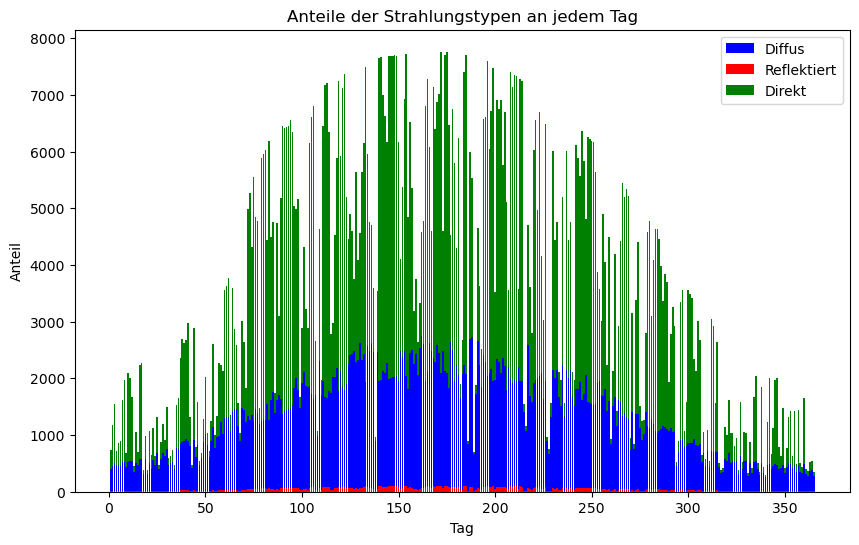

In [110]:
#Plot
fig, ax = plt.subplots(figsize=(10, 6))
days = np.arange(1, 366)

#ax.bar(days, reflected_fraction[:365], label='Reflektiert', color='green')
ax.bar(days, diffuse_fraction[:365], label='Diffus', color='blue')
ax.bar(days, reflected_fraction[:365], label='Reflektiert', color='red')
ax.bar(days, direct_fraction[:365], bottom = diffuse_fraction[:365], label='Direkt', color='green')

ax.set_title('Anteile der Strahlungstypen an jedem Tag')
ax.set_xlabel('Tag')
ax.set_ylabel('Anteil')
ax.legend()
plt.show()

## e.) Vergeleich durchschnittlicher Stromproduktion am Tag für Juni/Dezember

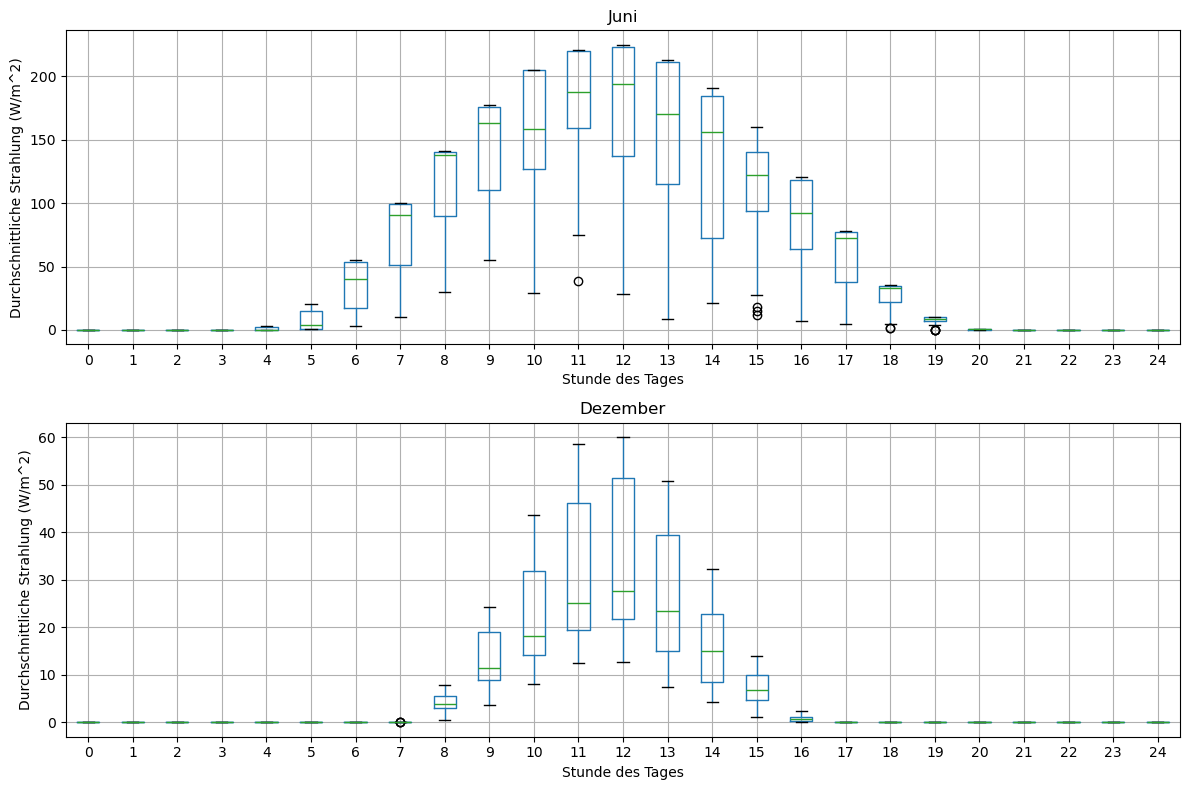

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

# Daten aus der CSV-Datei laden
df = pd.read_csv("Strahlung.csv")

# Konvertiere die Stundenangaben in Ganzzahlen für die Gruppierung
df['Hour'] = df['Hour'].astype(int)

# Extrahiere die Daten für die Monate Juni und Dezember
june_data = df[(df['Month'] == 6)]
december_data = df[(df['Month'] == 12)]

# Gruppiere die Daten nach Tag und Stunde und berechne den Durchschnitt pro Stunde
june_hourly_avg = june_data.groupby(['Day', 'Hour'])['GlobalHoriz'].mean().unstack()
december_hourly_avg = december_data.groupby(['Day', 'Hour'])['GlobalHoriz'].mean().unstack()

# Erstelle Boxplots für die durchschnittliche Strahlung für jede Stunde des Tages für Juni und Dezember
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

june_hourly_avg.boxplot(ax=axes[0])
axes[0].set_title('Juni')
axes[0].set_xlabel('Stunde des Tages')
axes[0].set_ylabel('Durchschnittliche Strahlung (W/m^2)')

december_hourly_avg.boxplot(ax=axes[1])
axes[1].set_title('Dezember')
axes[1].set_xlabel('Stunde des Tages')
axes[1].set_ylabel('Durchschnittliche Strahlung (W/m^2)')

plt.tight_layout()
plt.show()

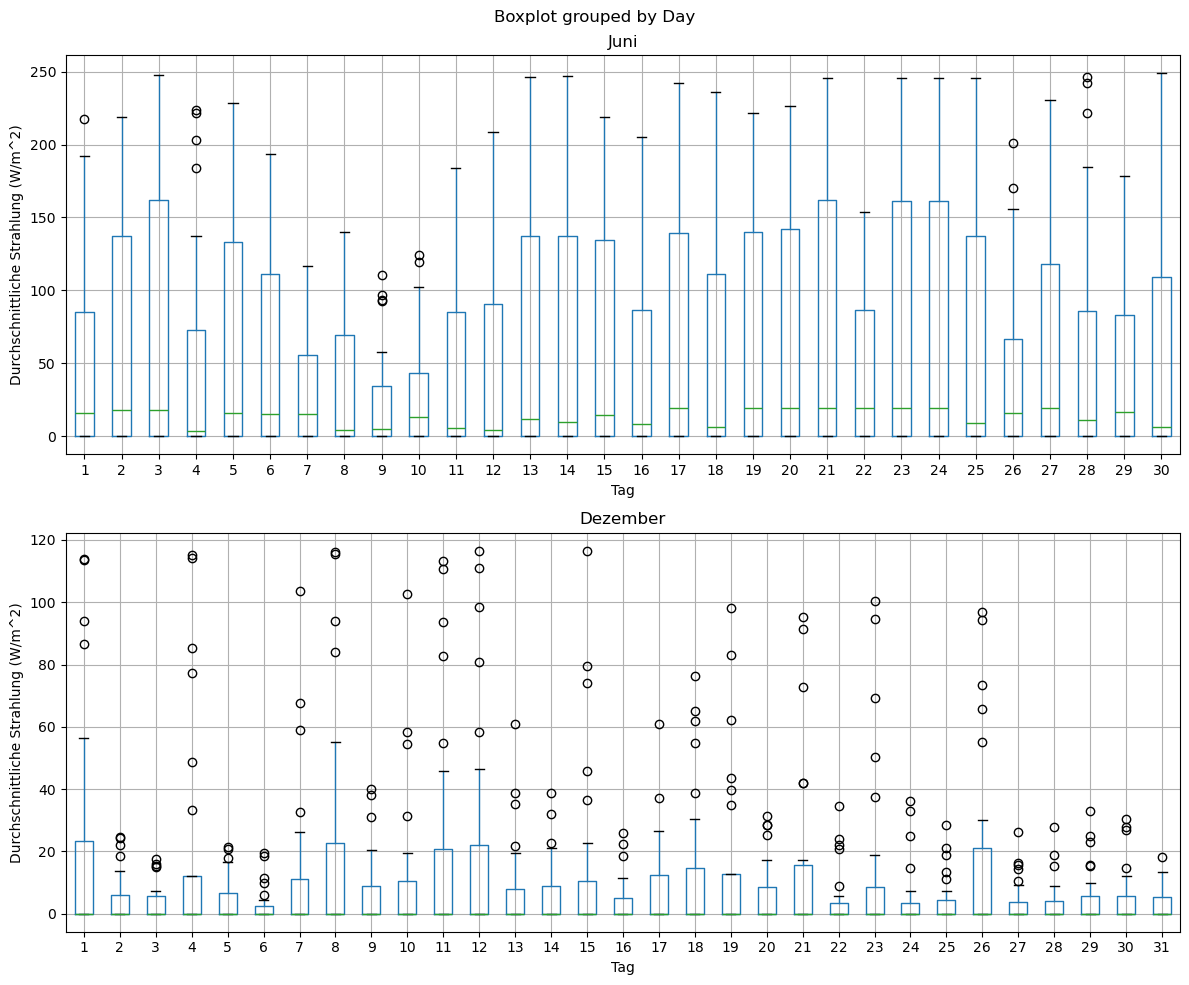

In [112]:

df = pd.read_csv("Strahlung.csv")

# Konvertiere die Stundenangaben in Ganzzahlen für die Gruppierung
df['Hour'] = df['Hour'].astype(int)

# Extrahiere die Daten für die Monate Juni und Dezember
june_data = df[df['Month'] == 6]
december_data = df[df['Month'] == 12]

# Gruppiere die Daten nach Jahr, Monat, Tag und Stunde und berechne den Durchschnitt pro Stunde
june_hourly_avg = june_data.groupby(['Year', 'Month', 'Day', 'Hour']).mean().reset_index()
december_hourly_avg = december_data.groupby(['Year', 'Month', 'Day', 'Hour']).mean().reset_index()

# Teile die summierten Werte durch 4, um den Durchschnitt pro Stunde zu erhalten
june_hourly_avg['GlobalHoriz'] /= 4
december_hourly_avg['GlobalHoriz'] /= 4

# Erstelle eine Matrix für die Strahlungswerte pro Stunde für jeden Tag im Juni und Dezember
june_hourly_matrix = june_hourly_avg.pivot_table(index='Hour', columns='Day', values='GlobalInclined')
december_hourly_matrix = december_hourly_avg.pivot_table(index='Hour', columns='Day', values='GlobalInclined')

# Erstelle Boxplots für die durchschnittliche Strahlung für jeden Tag in Juni und Dezember
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

june_hourly_avg.boxplot(column='GlobalInclined', by='Day', ax=axes[0])
axes[0].set_title('Juni')
axes[0].set_xlabel('Tag')
axes[0].set_ylabel('Durchschnittliche Strahlung (W/m^2)')

december_hourly_avg.boxplot(column='GlobalInclined', by='Day', ax=axes[1])
axes[1].set_title('Dezember')
axes[1].set_xlabel('Tag')
axes[1].set_ylabel('Durchschnittliche Strahlung (W/m^2)')

plt.tight_layout()
plt.show()

## 5.) Übungangabe V: Aufstellwinkel und Ausrichtung:

In [113]:

P = jahreserzeugung(laengengrad,breitengrad, Installpv, Modulwirkungsgrad, pv_hoehenwinkel, pv_azimut, SonstigeVerluste,A, dfTime)
steps_hw = 37 #37
steps_az = 36 #37
vals = np.zeros((steps_hw, steps_az))
for i in range(steps_hw):   
    pv_hoehenwinkel = i*2.5
    S_hWinkel = pd.Series(name = str(pv_hoehenwinkel))


    for j in range(steps_az): 
        pv_azimut = j*10
        vals[i,j] = jahreserzeugung(laengengrad,breitengrad, Installpv, Modulwirkungsgrad, pv_hoehenwinkel, pv_azimut, SonstigeVerluste,A, dfTime).sum()
        print(str(pv_hoehenwinkel) + '; ' + str(pv_azimut))
        
        
    

print(vals)

#print(type(P))
dfIndex = dfTime.loc[dfTime["Monat"] == 6]
dfIndex.index
print("Stromproduktion Juni:" + str(round(P[dfIndex.index].sum()*10**(-3), 5)) + " kWh")


96
Jährliche Stromerzeugung (ohne Temp): 995.2412 kWh
Jährliche Volllaststunden (ohne Temp): 995.2412 h/a
96
Jährliche Stromerzeugung (ohne Temp): 906.33792 kWh
Jährliche Volllaststunden (ohne Temp): 906.33792 h/a
0.0; 0
96
Jährliche Stromerzeugung (ohne Temp): 906.33792 kWh
Jährliche Volllaststunden (ohne Temp): 906.33792 h/a
0.0; 10
96
Jährliche Stromerzeugung (ohne Temp): 906.33792 kWh
Jährliche Volllaststunden (ohne Temp): 906.33792 h/a
0.0; 20
96
Jährliche Stromerzeugung (ohne Temp): 906.33792 kWh
Jährliche Volllaststunden (ohne Temp): 906.33792 h/a
0.0; 30
96
Jährliche Stromerzeugung (ohne Temp): 906.33792 kWh
Jährliche Volllaststunden (ohne Temp): 906.33792 h/a
0.0; 40
96
Jährliche Stromerzeugung (ohne Temp): 906.33792 kWh
Jährliche Volllaststunden (ohne Temp): 906.33792 h/a
0.0; 50
96
Jährliche Stromerzeugung (ohne Temp): 906.33792 kWh
Jährliche Volllaststunden (ohne Temp): 906.33792 h/a
0.0; 60
96
Jährliche Stromerzeugung (ohne Temp): 906.33792 kWh
Jährliche Volllaststunden (o

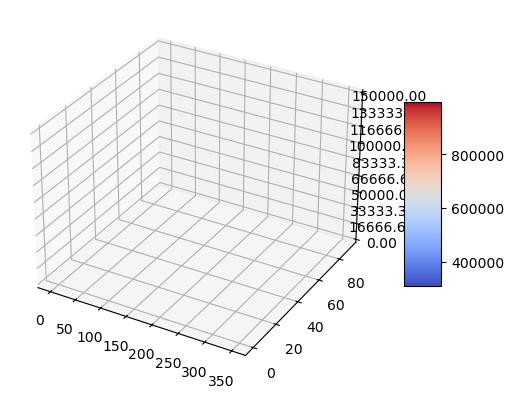

In [114]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
Y = np.arange(0, 92.5, 2.5)
X = np.arange(0, 360, 10)
X, Y = np.meshgrid(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, vals, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 150000)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()